In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
#import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [4]:
from simulator import Simulator, div

GPUs found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def force(m,n, w):
    f = np.zeros((m,n,2))
    f[-38:-2,25:45,0] = (-1 - w[-38:-2,25:45,0])
    f[2:38,55:75,0] = (1 - w[2:38,55:75,0])
    f += np.random.normal(size=(m,n,2))/3
    return f

def border_condition(w):
    w[0,:,0] = 0
    w[-1,:,0] = 0
    w[:,0,1] = 0
    w[:,-1,1] = 0

In [6]:
m,n = 80,100
sim = Simulator(m,n, 1, 0.01, border_condition, force)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
CPU times: user 32.3 s, sys: 860 ms, total: 33.2 s
Wall time: 28.6 s


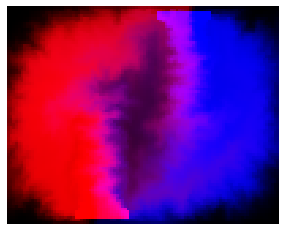

In [12]:
%%time

x = np.zeros((m,n,3))
x[-5:-2,40:60,0] = 1.0
x[2:5,40:60,2] = 1.0


def take_scalar(a,indices_i, indices_j) :
    m,n = a.shape[:2]
    full_idices = n*indices_i + indices_j
    reshaped = a.reshape(m*n)
    res = np.take(reshaped,full_idices, axis=0)
    return res.reshape(m,n)

def update_scalar(s,w,dt) :
    m,n = w.shape[:2]
    indices = np.indices((m,n)).swapaxes(0,2).swapaxes(0,1) - dt*w
    indices_floor = np.floor(indices).astype(np.int)
    frac = indices-indices_floor
    frac = [1-frac,frac]
    indices_ceil = indices_floor + 1
    indices_floor[:,:,0] = np.clip(indices_floor[:,:,0], 0, m-1)
    indices_ceil[:,:,0] = np.clip(indices_ceil[:,:,0], 0, m-1)
    indices_floor[:,:,1] = np.clip(indices_floor[:,:,1], 0, n-1)
    indices_ceil[:,:,1] = np.clip(indices_ceil[:,:,1], 0, n-1)
    indices = [indices_floor, indices_ceil] # shape : 2 m,n,2

    res = np.zeros((m,n))
    for i in range(2) :
        for j in range(2) :
            res += np.reshape(frac[i][:,:,0]*frac[j][:,:,1], (m,n)) * take_scalar(s, indices[i][:,:,0], indices[j][:,:,1])
    res = res*1
    #res[0:2,40:60] = 1
    return res

fig = plt.figure()
ims = []
for i in range(300) :
    dt=1
    sim.time_step(dt)
    x[:,:,0] = update_scalar(x[:,:,0],sim.w,dt)
    x[:,:,1] = update_scalar(x[:,:,1],sim.w,dt)
    x[:,:,2] = update_scalar(x[:,:,2],sim.w,dt)
    
    if i<3000:
        x[2:5,55:75,2] = 1.0
        x[-5:-2,25:45,0] = 1.0
    else:
        x[2:5,55:75,1] = 1.0
        x[-5:-2,25:45,2] = 1.0
    if not i % 20 :
        print(i)
    if not i % 3 :
        plt.axis('off')
        ims.append([plt.imshow(x, animated=True)])

In [8]:
ani1 = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani1.to_html5_video())
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)
#ani1.save('colorblend.mp4', writer=writer)

In [9]:
import cProfile
def test_func() :
    for i in range(100) :
        sim.time_step(dt)
cProfile.run('test_func()', 'restats')

In [20]:
import pstats
p = pstats.Stats('restats')
p.sort_stats('cumulative').print_stats(50)

Tue Nov 19 15:51:09 2019    restats

         10829706 function calls (10739044 primitive calls) in 12.015 seconds

   Ordered by: cumulative time
   List reduced from 456 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.015   12.015 {built-in method builtins.exec}
        1    0.000    0.000   12.015   12.015 <string>:1(<module>)
        1    0.000    0.000   12.015   12.015 <ipython-input-14-79df4a85f0ea>:2(test_func)
      100    0.003    0.000   12.015    0.120 /Data/leo_h/stable-fluids/simulator.py:194(time_step)
      100    0.004    0.000   10.015    0.100 /Data/leo_h/stable-fluids/simulator.py:174(compute_w4)
      100    0.036    0.000    9.817    0.098 /Data/leo_h/stable-fluids/simulator.py:59(conjgrad_lap)
     3809    0.113    0.000    8.365    0.002 /Data/leo_h/stable-fluids/simulator.py:50(conjgrad_lap_step)
   154815    4.969    0.000    4.971    0.000 {built-in method _pywrap_tensorfl